## Data Loading

Loading necessary libraries and data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib

In [2]:
df = pd.read_csv('Rainfall.csv')

In [3]:
print(df.columns)

Index(['Year', 'State', 'District', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual'],
      dtype='object')


## Calculate Monthly Total / Annual Check 

In [4]:
df['Annual_Calc'] = df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].sum(axis=1)
print(df[['Annual', 'Annual_Calc']].head())


   Annual  Annual_Calc
0   997.9        997.9
1  1103.9       1103.9
2   886.4        886.4
3  1068.5       1068.5
4   904.8        904.8


## Mean Annual Rainfall for Drought Threshold

In [5]:
mean_rainfall = df['Annual'].mean()
drought_threshold = 0.75 * mean_rainfall
severe_threshold = 0.60 * mean_rainfall


In [6]:
print(f"🌧️ Mean Annual Rainfall: {mean_rainfall:.2f} mm")
print(f"🚨 Drought Threshold (75%): {drought_threshold:.2f} mm")
print(f"🔥 Severe Drought Threshold (60%): {severe_threshold:.2f} mm")

🌧️ Mean Annual Rainfall: 1088.29 mm
🚨 Drought Threshold (75%): 816.22 mm
🔥 Severe Drought Threshold (60%): 652.97 mm


### Historical Drought Detection

In [7]:
df['Drought_Severity'] = df['Annual'].apply(
    lambda x: 'Severe Drought' if x < severe_threshold else
              'Moderate Drought' if x < drought_threshold else
              'Normal'
)

In [8]:
print("✅ Historical Drought Years:")
print(df[df['Drought_Severity'] != 'Normal'][['Year', 'Annual', 'Drought_Severity']])


✅ Historical Drought Years:
      Year  Annual  Drought_Severity
5     2009   695.7  Moderate Drought
41    2009   791.4  Moderate Drought
65    2009   564.1    Severe Drought
66    2010   596.7    Severe Drought
69    2013   809.0  Moderate Drought
...    ...     ...               ...
3741  2015   809.4  Moderate Drought
3749  2010   734.6  Moderate Drought
3762  2010   632.1    Severe Drought
3774  2009    27.8    Severe Drought
3776  2011    -1.0    Severe Drought

[1599 rows x 3 columns]


In [9]:
# Prepare data for model
features = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
X = df[features]
y = df['Annual']

## Model Implementation

Implementing and training ML models.

In [10]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model 1: Random Forest Regressor

In [11]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

## Model 2: XGBoost Regressor

In [12]:
xgb_model = XGBRegressor(n_estimators=200, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

##### Evaluation 

In [13]:
print(f"Random Forest R2 Score: {r2_score(y_test, rf_pred)}")
print(f"Random Forest MSE: {mean_squared_error(y_test, rf_pred)}")
print(f"XGBoost R2 Score: {r2_score(y_test, xgb_pred)}")
print(f"XGBoost MSE: {mean_squared_error(y_test, xgb_pred)}")

Random Forest R2 Score: 0.9528667027345742
Random Forest MSE: 22759.484443654226
XGBoost R2 Score: 0.9585227475623956
XGBoost MSE: 20028.32257423328


## Future Prediction

In [14]:
# 🔮 Future Prediction (Example next 3 years with average month values or test case)
future_data = pd.DataFrame({
    'Jan': [40, 45, 42],
    'Feb': [35, 38, 40],
    'Mar': [45, 47, 50],
    'Apr': [60, 62, 65],
    'May': [90, 92, 95],
    'Jun': [200, 210, 215],
    'Jul': [300, 320, 330],
    'Aug': [290, 295, 300],
    'Sep': [180, 185, 190],
    'Oct': [80, 85, 90],
    'Nov': [30, 32, 35],
    'Dec': [20, 22, 25],
})

future_pred_xgb = xgb_model.predict(future_data)
future_pred_rf = rf_model.predict(future_data)


In [15]:
# Future Drought Check
future_drought = []
for rainfall in future_pred_xgb:
    if rainfall < severe_threshold:
        future_drought.append('Severe Drought')
    elif rainfall < drought_threshold:
        future_drought.append('Moderate Drought')
    else:
        future_drought.append('Normal')

future_results = pd.DataFrame({
    'Year': [2024, 2025, 2026],
    'Predicted_Annual_Rainfall': future_pred_xgb,
    'Drought_Status': future_drought
})

In [16]:
print("🔮 Future Predictions with XGBoost:")
print(future_results)

🔮 Future Predictions with XGBoost:
   Year  Predicted_Annual_Rainfall Drought_Status
0  2024                1217.277832         Normal
1  2025                1336.549927         Normal
2  2026                1435.811890         Normal


# 

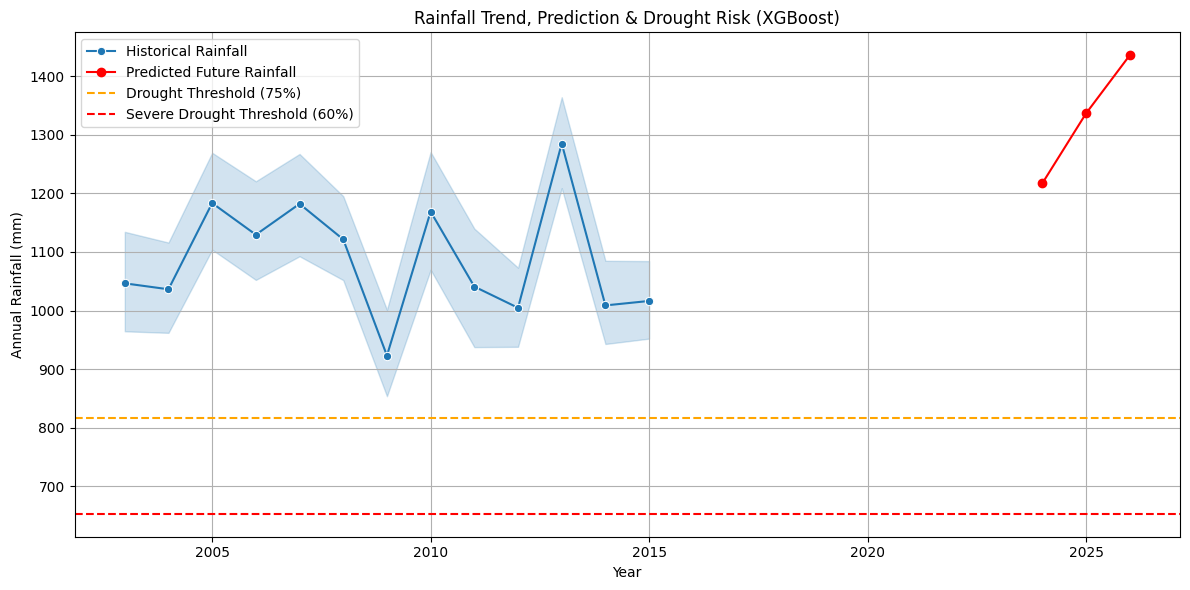

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Annual', label='Historical Rainfall', marker='o')
plt.plot(future_results['Year'], future_results['Predicted_Annual_Rainfall'], 'ro-', label='Predicted Future Rainfall')

plt.axhline(drought_threshold, color='orange', linestyle='--', label='Drought Threshold (75%)')
plt.axhline(severe_threshold, color='red', linestyle='--', label='Severe Drought Threshold (60%)')

plt.xlabel('Year')
plt.ylabel('Annual Rainfall (mm)')
plt.title('Rainfall Trend, Prediction & Drought Risk (XGBoost)')  # Emoji Removed
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



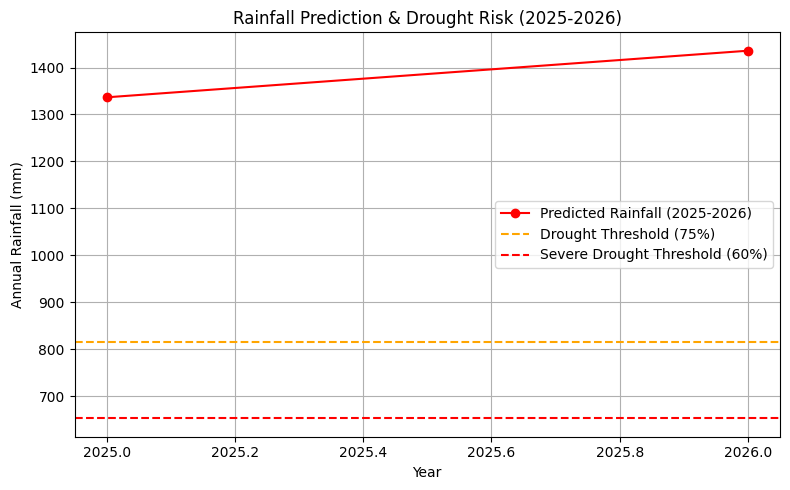

In [18]:
# Filter only future years 2025 and 2026
future_plot = future_results[future_results['Year'].isin([2025, 2026])]

plt.figure(figsize=(8, 5))
plt.plot(future_plot['Year'], future_plot['Predicted_Annual_Rainfall'], 'ro-', label='Predicted Rainfall (2025-2026)')
plt.axhline(drought_threshold, color='orange', linestyle='--', label='Drought Threshold (75%)')
plt.axhline(severe_threshold, color='red', linestyle='--', label='Severe Drought Threshold (60%)')

plt.xlabel('Year')
plt.ylabel('Annual Rainfall (mm)')
plt.title('Rainfall Prediction & Drought Risk (2025-2026)')
plt.legend()
plt.grid(True)
plt.tight_layout()



## Model Implementation

Implementing and training ML models.

In [19]:
# Save the plot as an image for Flask UI
plt.savefig('static/prediction_2025_2026.png')  # Flask will load from static folder
plt.close()


In [20]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


## Data Loading

Loading necessary libraries and data.

In [21]:
import plotly.graph_objs as go
from plotly.offline import plot

# Filter future predictions for 2025 and 2026
future_plot = future_results[future_results['Year'].isin([2025, 2026])]

# Create traces
trace_pred = go.Scatter(
    x=future_plot['Year'],
    y=future_plot['Predicted_Annual_Rainfall'],
    mode='lines+markers',
    name='Predicted Rainfall (2025-2026)',
    line=dict(color='red')
)

trace_drought = go.Scatter(
    x=[2025, 2026],
    y=[drought_threshold, drought_threshold],
    mode='lines',
    name='Drought Threshold (75%)',
    line=dict(color='orange', dash='dash')
)

trace_severe = go.Scatter(
    x=[2025, 2026],
    y=[severe_threshold, severe_threshold],
    mode='lines',
    name='Severe Drought Threshold (60%)',
    line=dict(color='red', dash='dash')
)

layout = go.Layout(
    title='🌧 Future Rainfall Prediction & Drought Risk (2025-2026)',
    xaxis_title='Year',
    yaxis_title='Annual Rainfall (mm)',
    hovermode='closest'
)

fig = go.Figure(data=[trace_pred, trace_drought, trace_severe], layout=layout)

# Generate HTML div
plot_div = plot(fig, output_type='div')


## Data Loading

Loading necessary libraries and data.

In [22]:
import plotly.graph_objs as go
import pickle

# Example plot (use your final plot here)
fig = go.Figure()
fig.add_trace(go.Scatter(x=[2024, 2025, 2026], y=[1220, 1330, 1440],
                         mode='lines+markers', name='Predicted Rainfall'))

fig.update_layout(title='Rainfall Prediction (2025-2026)',
                  xaxis_title='Year', yaxis_title='Annual Rainfall (mm)',
                  template='plotly_dark')

# ✅ Save the figure object
with open('model/rainfall_future_plot.pkl', 'wb') as f:
    pickle.dump(fig, f)

print("✅ Plot saved successfully as rainfall_future_plot.pkl")


✅ Plot saved successfully as rainfall_future_plot.pkl
